In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Sat Jan 27 01:05:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   51C    P0   106W / 300W |   8299MiB / 80994MiB |     25%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-7_hardquantize/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

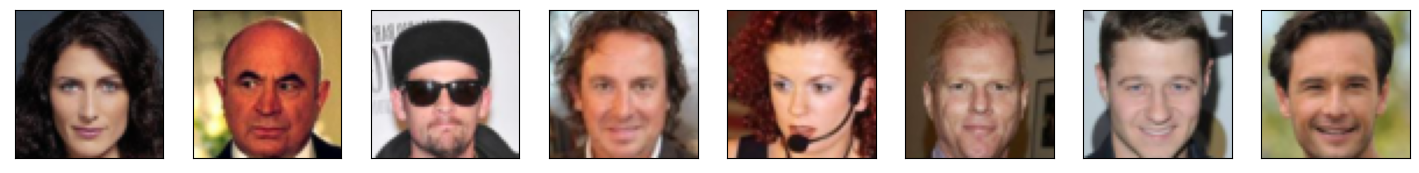

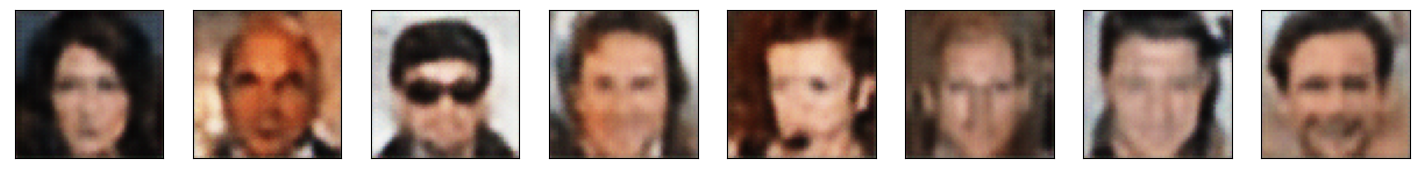

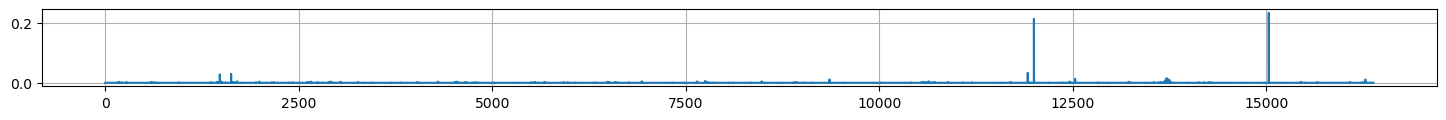

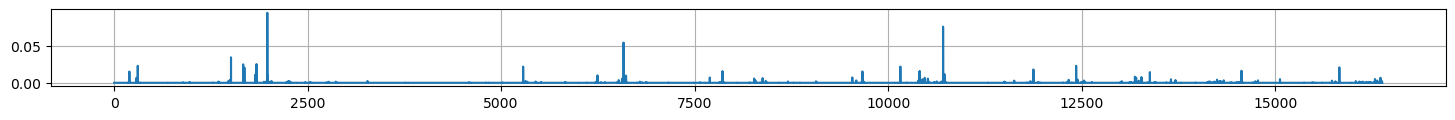

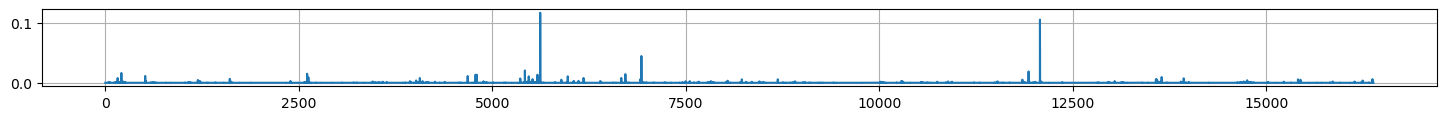

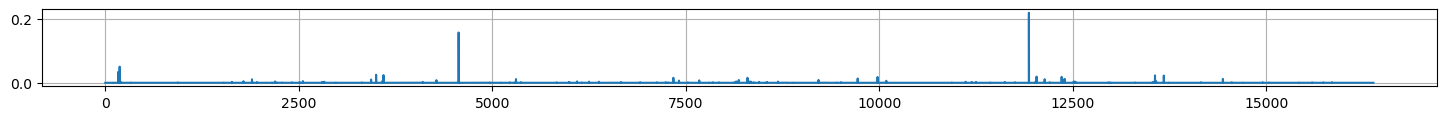

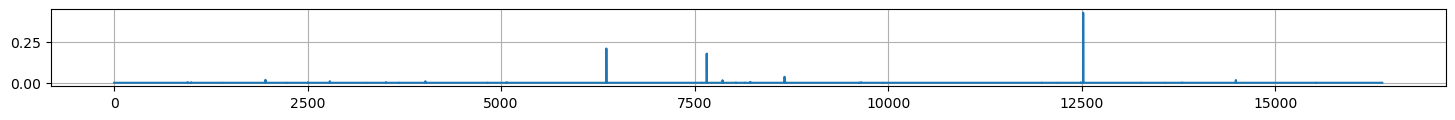

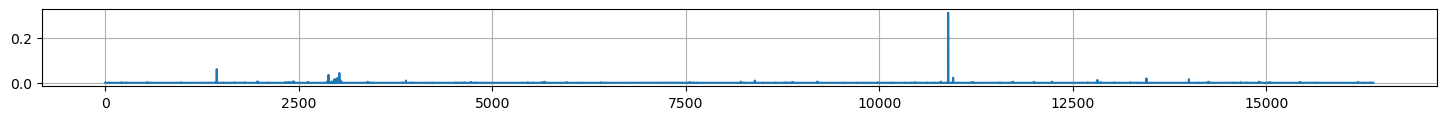

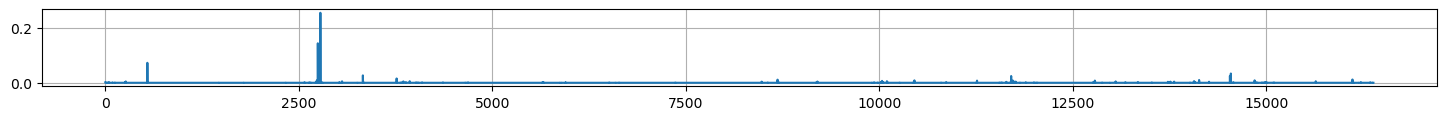

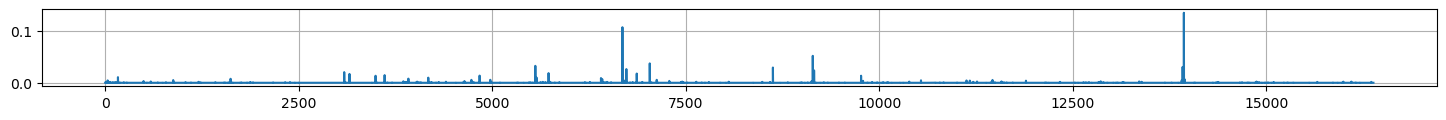

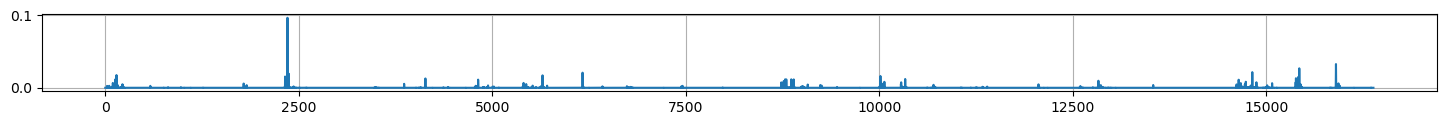

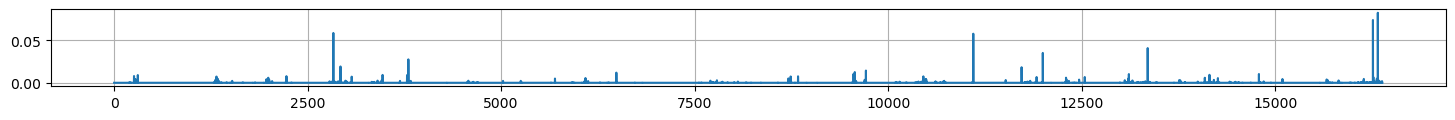

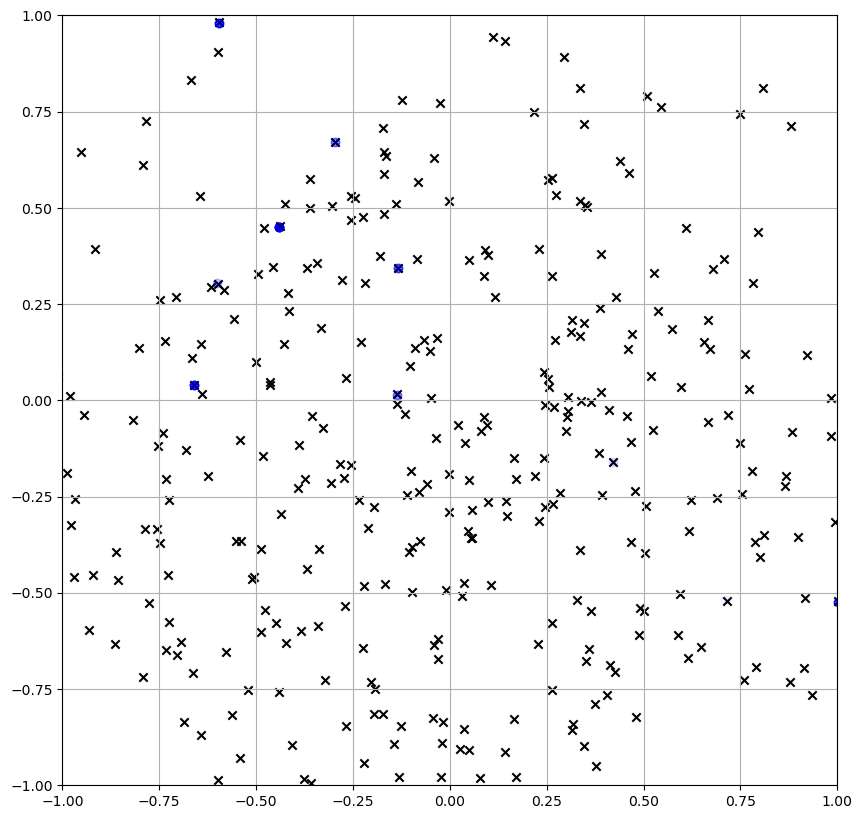

1001
lse_loss -9.619376182556152
commit_loss 0.33481448888778687
recon_loss 0.006876922678202391
1002
lse_loss -9.63636302947998
commit_loss 0.34031203389167786
recon_loss 0.00534436572343111
1003
lse_loss -9.663126945495605
commit_loss 0.3360884189605713
recon_loss 0.005514288321137428
1004
lse_loss -9.59772777557373
commit_loss 0.3382435441017151
recon_loss 0.005560989957302809
1005
lse_loss -9.643786430358887
commit_loss 0.34086382389068604
recon_loss 0.00572437746450305
1006
lse_loss -9.638056755065918
commit_loss 0.3368961215019226
recon_loss 0.0051744189113378525
1007
lse_loss -9.61620807647705
commit_loss 0.3405326306819916
recon_loss 0.005434319376945496
1008
lse_loss -9.647894859313965
commit_loss 0.34087422490119934
recon_loss 0.005509919486939907
1009
lse_loss -9.751704216003418
commit_loss 0.3379248380661011
recon_loss 0.006123565137386322
1010
lse_loss -9.660460472106934
commit_loss 0.3379357159137726
recon_loss 0.005799129605293274
1011
lse_loss -9.652731895446777
commit_

1089
lse_loss -9.748642921447754
commit_loss 0.3401586711406708
recon_loss 0.005784430541098118
1090
lse_loss -9.725443840026855
commit_loss 0.3424856662750244
recon_loss 0.006111588329076767
1091
lse_loss -9.776633262634277
commit_loss 0.3354029059410095
recon_loss 0.005823512561619282
1092
lse_loss -9.722563743591309
commit_loss 0.3430800437927246
recon_loss 0.005939552094787359
1093
lse_loss -9.694918632507324
commit_loss 0.3435213565826416
recon_loss 0.005630805157124996
1094
lse_loss -9.7664213180542
commit_loss 0.3353743255138397
recon_loss 0.005288881249725819
1095
lse_loss -9.82300853729248
commit_loss 0.3377114534378052
recon_loss 0.005875422619283199
1096
lse_loss -9.832480430603027
commit_loss 0.334858238697052
recon_loss 0.006007528863847256
1097
lse_loss -9.624815940856934
commit_loss 0.34144631028175354
recon_loss 0.005466026719659567
1098
lse_loss -9.722031593322754
commit_loss 0.33541256189346313
recon_loss 0.005611784290522337
1099
lse_loss -9.800873756408691
commit_lo

1176
lse_loss -9.812087059020996
commit_loss 0.32874512672424316
recon_loss 0.005777017679065466
1177
lse_loss -9.907912254333496
commit_loss 0.3283599615097046
recon_loss 0.004904261790215969
1178
lse_loss -9.765652656555176
commit_loss 0.333648145198822
recon_loss 0.005845801904797554
1179
lse_loss -9.889044761657715
commit_loss 0.3333064317703247
recon_loss 0.005440745502710342
1180
lse_loss -9.766770362854004
commit_loss 0.33760350942611694
recon_loss 0.004966964013874531
1181
lse_loss -9.805668830871582
commit_loss 0.33163028955459595
recon_loss 0.0056213876232504845
1182
lse_loss -9.811030387878418
commit_loss 0.33365577459335327
recon_loss 0.005644199904054403
1183
lse_loss -9.87984561920166
commit_loss 0.33461663126945496
recon_loss 0.005398879759013653
1184
lse_loss -9.7940092086792
commit_loss 0.3356475830078125
recon_loss 0.0052296775393188
1185
lse_loss -9.882601737976074
commit_loss 0.33323848247528076
recon_loss 0.005463339388370514
1186
lse_loss -9.91279125213623
commit_

1262
lse_loss -10.043852806091309
commit_loss 0.32626861333847046
recon_loss 0.004913635551929474
1263
lse_loss -10.03040599822998
commit_loss 0.3272480368614197
recon_loss 0.0055205924436450005
1264
lse_loss -10.08492374420166
commit_loss 0.3241727948188782
recon_loss 0.005651208572089672
1265
lse_loss -10.002551078796387
commit_loss 0.3252338767051697
recon_loss 0.0049227639101445675
1266
lse_loss -10.02027416229248
commit_loss 0.32270166277885437
recon_loss 0.006352047901600599
1267
lse_loss -10.171334266662598
commit_loss 0.3209249675273895
recon_loss 0.005737216677516699
1268
lse_loss -9.979557991027832
commit_loss 0.3254719376564026
recon_loss 0.0057226670905947685
1269
lse_loss -10.083022117614746
commit_loss 0.32128629088401794
recon_loss 0.005239601247012615
1270
lse_loss -10.07751178741455
commit_loss 0.3275933563709259
recon_loss 0.005821944214403629
1271
lse_loss -10.024977684020996
commit_loss 0.32470178604125977
recon_loss 0.005755558609962463
1272
lse_loss -10.0169153213

1349
lse_loss -10.120877265930176
commit_loss 0.32523420453071594
recon_loss 0.004976327531039715
1350
lse_loss -10.18210506439209
commit_loss 0.3283767104148865
recon_loss 0.005068618804216385
1351
lse_loss -10.176005363464355
commit_loss 0.3278638422489166
recon_loss 0.0051989927887916565
1352
lse_loss -10.202242851257324
commit_loss 0.3231925964355469
recon_loss 0.005907519720494747
1353
lse_loss -10.234942436218262
commit_loss 0.32364293932914734
recon_loss 0.005567122250795364
1354
lse_loss -10.216361045837402
commit_loss 0.3278685510158539
recon_loss 0.004816526081413031
1355
lse_loss -10.22629451751709
commit_loss 0.3277014195919037
recon_loss 0.005065434612333775
1356
lse_loss -10.28780460357666
commit_loss 0.3227372169494629
recon_loss 0.0047630490735173225
1357
lse_loss -10.237208366394043
commit_loss 0.32190805673599243
recon_loss 0.005261095240712166
1358
lse_loss -10.153801918029785
commit_loss 0.3267870843410492
recon_loss 0.005026155151426792
1359
lse_loss -10.2685899734

1434
lse_loss -10.464421272277832
commit_loss 0.32367148995399475
recon_loss 0.0063376943580806255
1435
lse_loss -10.366560935974121
commit_loss 0.3285474181175232
recon_loss 0.005396932363510132
1436
lse_loss -10.503266334533691
commit_loss 0.32329994440078735
recon_loss 0.005381348542869091
1437
lse_loss -10.350409507751465
commit_loss 0.32561194896698
recon_loss 0.004742406774312258
1438
lse_loss -10.409773826599121
commit_loss 0.3276599943637848
recon_loss 0.00451222900301218
1439
lse_loss -10.388087272644043
commit_loss 0.32763567566871643
recon_loss 0.00530679477378726
1440
lse_loss -10.266749382019043
commit_loss 0.32603907585144043
recon_loss 0.004738618619740009
1441
lse_loss -10.350754737854004
commit_loss 0.3261643052101135
recon_loss 0.005018805619329214
1442
lse_loss -10.536181449890137
commit_loss 0.32184937596321106
recon_loss 0.00539631862193346
1443
lse_loss -10.465060234069824
commit_loss 0.324585884809494
recon_loss 0.004920072853565216
1444
lse_loss -10.412983894348

1520
lse_loss -10.366042137145996
commit_loss 0.32343560457229614
recon_loss 0.004570826422423124
1521
lse_loss -10.5126371383667
commit_loss 0.3249260187149048
recon_loss 0.004734235815703869
1522
lse_loss -10.492999076843262
commit_loss 0.3274357318878174
recon_loss 0.005293457768857479
1523
lse_loss -10.518366813659668
commit_loss 0.32494890689849854
recon_loss 0.004995412193238735
1524
lse_loss -10.563944816589355
commit_loss 0.32431939244270325
recon_loss 0.004531665705144405
1525
lse_loss -10.529202461242676
commit_loss 0.32576659321784973
recon_loss 0.004801127128303051
1526
lse_loss -10.549193382263184
commit_loss 0.3230782449245453
recon_loss 0.005051180720329285
1527
lse_loss -10.70300579071045
commit_loss 0.32116809487342834
recon_loss 0.005251702852547169
1528
lse_loss -10.568610191345215
commit_loss 0.3249673843383789
recon_loss 0.004771561827510595
1529
lse_loss -10.56299877166748
commit_loss 0.327004075050354
recon_loss 0.005900237709283829
1530
lse_loss -10.595423698425

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp=0)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-7
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 